In [1]:
%pylab inline
import numpy as np
import scipy
import io
import base64
from IPython.display import HTML, Image
from scipy.stats import binom, poisson
from matplotlib.collections import PatchCollection
from matplotlib.patches import Circle, Rectangle

## Customising the font size
plt.rcParams.update({'font.size': 14})
plt.rcParams['figure.figsize'] = 24,8
plt.rcParams['figure.dpi'] = 150

Populating the interactive namespace from numpy and matplotlib


# Lecture Notes Week 8

## Syllabus
1. Errors, Probabilities, and Interpretations; basics of presentation of data, mean, spread
2. Probability distributions
3. Monte Carlo basics
4. Parameter Estimation
5. Maximum Likelihood + extended maximum likelihood
6. Least Square, chi2, correlations, Best Linear Unbiased Estimator
7. **Probability and Confidence level** 
8. **Hypothesis testing**
9. Goodness of fit tests 
10. Limit setting
11. Introduction to Multivariate Analysis Techniques
12. Basics of Unfolding

## Recap

<img src="files/Confidence_90_belt.png" width=60% >
<img src="files/Confidence_90.png" width=60% >

## Confidence level

### Binomial confidence intervals

For Binomial distributions, events belong to exactly one of two classes, e.g. true or false, greater or smaller than a threshold, male or female, etc. This applies to samples of finite size and so the observed events are discretely distributed. Contrary to that the true variable is continuous, e.g. the probability for an event to be true can take any value and even the expectation value, i.e. the probability multiplied by the sample size is not necessarily an integer.

#### Recall the Binomial distribution

$$P(r;p,n)=p^r(1-p)^{n-r}\frac{n!}{r!(n-r)!},$$

where $p$ is the probability of success, $n$ is the sample size, and $r$ is the number of successes for this sample.

The expectation value is

$$<r>=np.$$

#### Construction of a Binomial confidence belt

Given that the distribution of events is discrete, the integrals used in the construction of confidence intervals have to be replaced by sums. Recall that for a central interval, for a given confidence level $C$, we have to determine 

$$\int_{-\infty}^{x_-}P(x)dx=\int_{x_+}^{\infty}P(x)dx=(1-C)/2.$$

The direct replacement would lead, for a given confidence level $C$, to

$$\sum_{r=0}^{r_-}P(r;p,n)=\sum_{r=r_+}^{n}P(r;p,n)=(1-C)/2.$$

In general the discrete nature of $r$ will prevent these equalities to be satisfied exactly. Therefore they have to be replaced by inequalities that guarantee that the confidence interval covered by the range $r_-$ to $r_+$ is _at least_ $C$. This is given by the following constructions

$$\sum_{r=0}^{r_+}P(r;p,n)\geq 1-(1-C)/2.$$

and

$$\sum_{r=r_-}^{n}P(r;p,n)\geq 1-(1-C)/2.$$

#### Example: Fraction of female students

In order for this excercise to be applicable to Binomial distributions, we need to work with exclusively two genders. Apologies to everyone who does not consider themselves falling into any of these categories.

Let's first establish the number of students in the course and those who are female. 

- Over to <a href="https://www.menti.com">menti.com</a> with code 66 97 10

In [2]:
nStudents = 20
nFemale = 6
cl = 0.90

#### Construction of a confidence belt based on these data

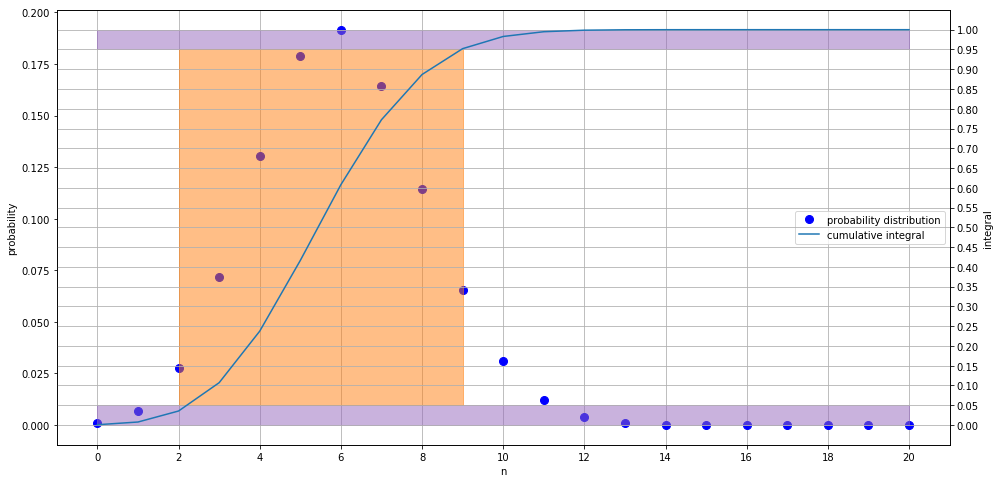

In [3]:
x = range(nStudents+1) # list of integers from 0 to nStudents
n = nStudents
p = 0.3                # example probability
limlow = (1-cl)/2      # lower limit of central confidence interval
limhigh = 1-limlow     # upper limit of central confidence interval
rv = binom(n, p)       # initialise binomial distribution
probs = rv.pmf(x)      # calculate binomial probabilities for all values of x and return list
ints = np.cumsum(probs, dtype=float) # calculate cumulative sum of probabilities

# work out limits of confidence interval based on cumulative sum of probabilities
x_low = 0
x_high = nStudents
for i in x:
    if ints[i]<limlow: x_low = i
    if ints[n-i]>limhigh: x_high = n-i

# prepare two plots with common x axis
#plt.xkcd()
fig,ax1 = plt.subplots(figsize=(16, 8))
ax1.set_xticks(x[0::2])
ax2 = ax1.twinx()

# draw two bands indicating the excluded part of the confidence level
pp = PatchCollection([Rectangle((0,0),n,limlow),Rectangle((0,limhigh),n,limlow)],alpha=0.5, color='tab:purple', label='outside CL')

# draw a rectangle indicating the selected confidence interval
pp2 = PatchCollection([Rectangle((x_low,limlow),x_high-x_low,cl)],alpha=0.5, color='tab:orange', label='selected range')

# add these to the plot
ax2.add_collection(pp)
ax2.add_collection(pp2)

# plot the probability distribution
ax1.plot(x,probs, 'bo', ms=8, label='probability distribution')

# plot the cumulative integral
ax2.plot(x,ints, '-', ms=8, label='cumulative integral')

# plot optics
ax2.set_yticks([x/20. for x in range(21)])
ax1.grid(which='both',axis='x')
ax2.grid(which='major',axis='y')
ax1.set_xlabel('n')
ax1.set_ylabel('probability')
ax2.set_ylabel('integral')

h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1+h2, l1+l2, loc=5)

plt.show()


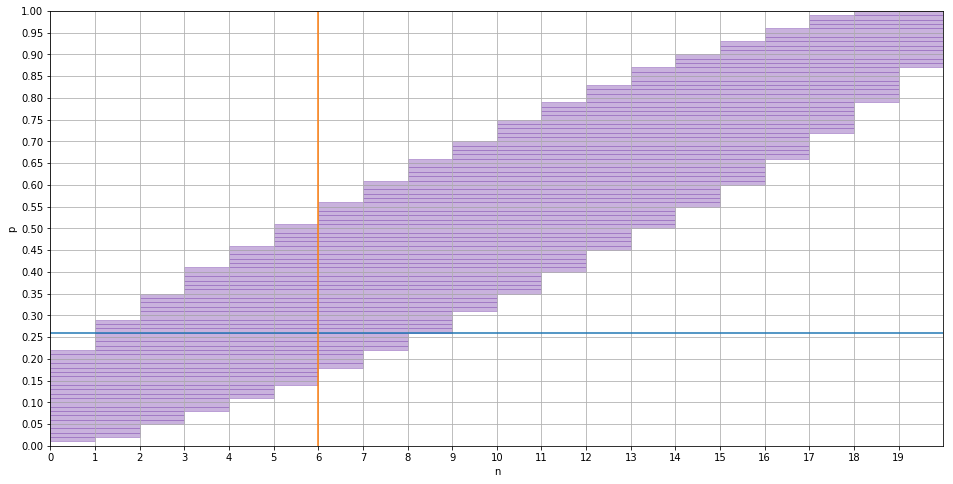

In [6]:
def binom_lower(q, n, p):
    # function to round properly when calculating confidence intervals
    rm = binom.ppf(q, n, p)
    rm1 = np.maximum(rm - 1, 0)
    return np.where( binom.cdf(rm,n,p)>q, rm1, rm)

def get_central_interval(cl, n, p):
    # calculate r- and r+ based on pre-defined functions
    rm = binom_lower(0.5*(1-cl)     , n, p)
    rp = binom.ppf(0.5*(1-cl) + cl, n, p)
    return rm, rp

def get_central_interval_details(cl, n, p):
    # calculate r- and r+ based on calculation of sums of probabilities
    sump = 0.
    summ = 0.
    foundp = False
    foundm = False
    rv = binom(n, p) # initialise binomial distribution
    for x in range(0,n+1):
        p = rv.pmf(x) # obtain probability
        sump += p
        if not foundp and 0.5*(1-cl) + cl <= sump: # check for first time exceeding threshold
            rp = x
            foundp = True
        p = rv.pmf(n-x) # obtain probability, summing up from maximum backwards
        summ += p
        if not foundm and 0.5*(1-cl) + cl <= summ: # check for first time exceeding threshold
            rm = n-x
            foundm = True
    return rm, rp

nSamples = 100 # defines granularity in y (=probability)
binom_patches = []
for i in range(1,nSamples):
    pFemale = 1. * i / nSamples # translate into probability
    #rm, rp = get_central_interval_details(0.95, nStudents, pFemale) # use detailed calculation
    rm, rp = get_central_interval(cl, nStudents, pFemale) # use fast implementation
    binom_patches.append( Rectangle((rm,pFemale),rp-rm,1./nSamples) ) # define drawing object for confidence interval
binoms = PatchCollection(binom_patches, alpha=0.5, color='tab:purple') # drawing object for complete belt

fig, ax = plt.subplots(figsize=(16, 8))
ax.set_xlim(0,nStudents) # set x axis range
ax.set_ylim(0,1)         # set y axis range

ax.add_collection(binoms) # draw belt

# plot optics
ax.set_yticks([x/20. for x in range(21)])
ax.set_xticks([x for x in range(nStudents)])
ax.grid(which='both',axis='x')
ax.grid(which='major',axis='y')
plt.xlabel('n')
plt.ylabel('p')

# reality check
#ax.plot([0,nStudents],[0.3]*2)
ax.plot([0,nStudents],[0.26]*2)
ax.plot([nFemale]*2,[0,1])

plt.show()


Finally, if $m$ successes are observed, the limits on the true probability can be assigned by

$$\sum_{r=m+1}^{n}P(r;p_+,n)= 1-(1-C)/2,$$

and

$$\sum_{r=0}^{m-1}P(r;p_-,n)= 1-(1-C)/2.$$

In practice, these are the outward-facing corners of the confidence belt at a position $r=m$. These are also known as the _Clopper-Pearson confidence limits_.

